In [1]:
import os
import random
import warnings
import numpy as np
from scipy import stats
from fitter import Fitter
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from kerashypetune import KerasGridSearch

In [2]:
### READ DATA ###

df = pd.read_csv('crime.csv.zip')
df['Date'] = pd.to_datetime(df[['YEAR','MONTH','DAY']])

df = pd.DataFrame({'n_crimes':df.Date.value_counts().sort_index()})
df['month'] = df.index.month
df['wday'] = df.index.dayofweek
df['day'] = df.index.day

print(df.shape)
df.head()

(5308, 4)


,n_crimes,month,wday,day
2003-01-01,191,1,2,1
2003-01-02,148,1,3,2
2003-01-03,160,1,4,3
2003-01-04,146,1,5,4
2003-01-05,120,1,6,5


Text(0, 0.5, 'daily crimes')

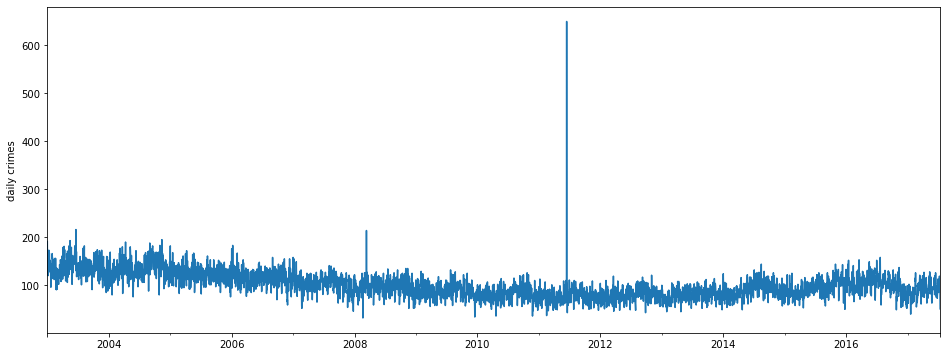

In [3]:
### PLOT AGGREGATED DAILY CRIMES ###

df.n_crimes.plot(figsize=(16,6))
plt.ylabel('daily crimes')

Text(0.5, 0, 'weekday')

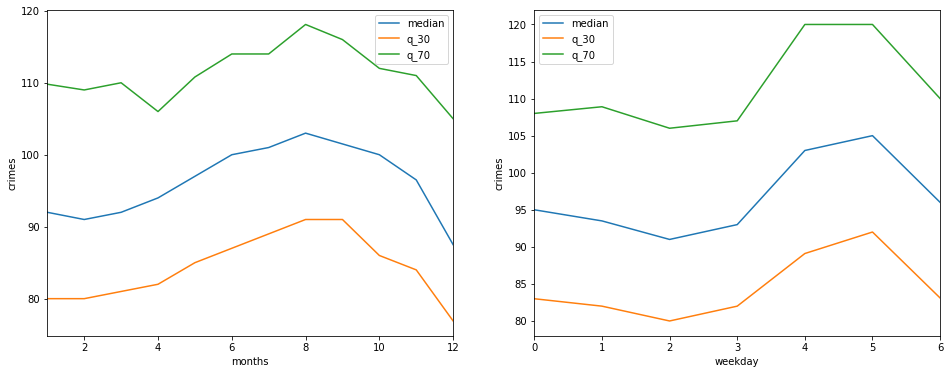

In [4]:
### PLOT SEASONALITY PATTERNS FOR CRIME SERIES ###

plt.figure(figsize=(16,6))

plt.subplot(121)
df.n_crimes.groupby(df.index.month).median().rename('median').plot(ax=plt.gca(), legend=True)
df.n_crimes.groupby(df.index.month).apply(np.quantile, 0.3).rename('q_30').plot(legend=True)
df.n_crimes.groupby(df.index.month).apply(np.quantile, 0.7).rename('q_70').plot(legend=True)
plt.ylabel('crimes'); plt.xlabel('months')

plt.subplot(122)
df.n_crimes.groupby(df.index.weekday).median().rename('median').plot(ax=plt.gca(), legend=True)
df.n_crimes.groupby(df.index.weekday).apply(np.quantile, 0.3).rename('q_30').plot(legend=True)
df.n_crimes.groupby(df.index.weekday).apply(np.quantile, 0.7).rename('q_70').plot(legend=True)
plt.ylabel('crimes'); plt.xlabel('weekday')

In [5]:
### DEFINE UTILITY FUNCTIONS ###

def create_windows(data, window_shape, step = 1, start_id = None, end_id = None):
    
    data = np.asarray(data)
    data = data.reshape(-1,1) if np.prod(data.shape) == max(data.shape) else data
        
    start_id = 0 if start_id is None else start_id
    end_id = data.shape[0] if end_id is None else end_id
    
    data = data[int(start_id):int(end_id),:]
    window_shape = (int(window_shape), data.shape[-1])
    step = (int(step),) * data.ndim
    slices = tuple(slice(None, None, st) for st in step)
    indexing_strides = data[slices].strides
    win_indices_shape = ((np.array(data.shape) - window_shape) // step) + 1
    
    new_shape = tuple(list(win_indices_shape) + list(window_shape))
    strides = tuple(list(indexing_strides) + list(data.strides))
    
    window_data = np.lib.stride_tricks.as_strided(data, shape=new_shape, strides=strides)
    
    return np.squeeze(window_data, 1)


class Scaler3D:
    
    def fit(self, X):
        self.mean = X.reshape(-1,X.shape[-1]).mean(0).reshape(1,1,-1)
        self.std = X.reshape(-1,X.shape[-1]).std(0).reshape(1,1,-1)
        return self
        
    def transform(self, X):
        return (X - self.mean) / self.std
    
    def inverse_transform(self, X):
        return (X * self.std) + self.mean

    
def prepare_seq(num_X, cat1_X, cat2_X, scaler=None):
    
    if scaler is not None:
        num_X = scaler.transform(num_X)
        
    inp_dict = {}
    inp_dict['inp_num'] = num_X
    for i,c in enumerate(cat_var):
        inp_dict[f"inp_{c}_cat1"] = cat1_X[:,:,i]
        inp_dict[f"inp_{c}_cat2"] = cat2_X[:,:,i]
    
    return inp_dict

In [6]:
### TRAIN VALID SPLIT AND SCALING ###

time_h = 7
window_shape = 21

target = ['n_crimes']
cat_var = ['month','wday','day']

_id_train, _id_valid = train_test_split(np.arange((len(df) - window_shape - time_h + 1)), test_size=0.3, shuffle=False)

_num_X = create_windows(df[target], window_shape=window_shape, end_id=-time_h)
_cat1_X = create_windows(df[cat_var], window_shape=window_shape, end_id=-time_h)
_cat2_X = create_windows(df[cat_var], window_shape=time_h, start_id=window_shape)
_target = create_windows(df[target], window_shape=time_h, start_id=window_shape)

_num_X_train = _num_X[_id_train]; _num_X_valid = _num_X[_id_valid]
_cat1_X_train = _cat1_X[_id_train]; _cat1_X_valid = _cat1_X[_id_valid]
_cat2_X_train = _cat2_X[_id_train]; _cat2_X_valid = _cat2_X[_id_valid]
_target_train = _target[_id_train]; _target_valid = _target[_id_valid]

X_scaler = Scaler3D().fit(_num_X_train)
y_scaler = Scaler3D().fit(_target_train)

X_train = prepare_seq(_num_X_train, _cat1_X_train, _cat2_X_train, scaler=X_scaler)
y_train = y_scaler.transform(_target_train)
X_valid = prepare_seq(_num_X_valid, _cat1_X_valid, _cat2_X_valid, scaler=X_scaler)
y_valid = y_scaler.transform(_target_valid)

In [7]:
### DEFINE MODEL STRUCTURE TO OPTIMIZE ###

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model(param):
    
    set_seed(33)
    
    inp_num = Input((window_shape,1), name='inp_num')
    
    embeddings = {
        'month': Embedding(12+1, param['emb_dim']),
        'wday': Embedding(6+1, param['emb_dim']),
        'day': Embedding(31+1, param['emb_dim'])
    }
    
    inp_cat1, emb_cat = [], []
    for c in cat_var:
        _inp_c1 = Input((window_shape,), name=f"inp_{c}_cat1")
        emb = embeddings[c](_inp_c1)
        inp_cat1.append(_inp_c1)
        emb_cat.append(emb)
    
    enc = Concatenate()([inp_num] + emb_cat)
    enc = LSTM(param['lstm_unit'], return_sequences=False)(enc)
    
    inp_cat2, emb_future = [], []
    for c in cat_var:
        _inp_c2 = Input((time_h,), name=f"inp_{c}_cat2")
        emb = embeddings[c](_inp_c2)
        inp_cat2.append(_inp_c2)
        emb_future.append(emb) 
    
    x = RepeatVector(time_h)(enc)
    dec = Concatenate()([x] + emb_future)
    dec = LSTM(param['lstm_unit'], return_sequences=True)(dec)
    
    output = TimeDistributed(Dense(1))(dec)
    
    model = Model([inp_num] + inp_cat1 + inp_cat2, output)
    model.compile(Adam(lr=param['lr']), 'mse')
    
    return model

In [8]:
### FIT AND OPTIMIZE MODEL ###

param_grid = {
    'lstm_unit': [128,64,32], 
    'emb_dim': [8,16,32],
    'lr': [1e-4,1e-3], 
    'epochs': 100, 
    'batch_size': 64
}

es = EarlyStopping(patience=7, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
hypermodel = get_model
kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[es])


18 trials detected for ('lstm_unit', 'emb_dim', 'lr', 'epochs', 'batch_size')

***** (1/18) *****
Search({'lstm_unit': 128, 'emb_dim': 8, 'lr': 0.0001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.21963 at epoch 24

***** (2/18) *****
Search({'lstm_unit': 128, 'emb_dim': 8, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.21379 at epoch 16

***** (3/18) *****
Search({'lstm_unit': 128, 'emb_dim': 16, 'lr': 0.0001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22076 at epoch 15

***** (4/18) *****
Search({'lstm_unit': 128, 'emb_dim': 16, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22021 at epoch 2

***** (5/18) *****
Search({'lstm_unit': 128, 'emb_dim': 32, 'lr': 0.0001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22114 at epoch 15

***** (6/18) *****
Search({'lstm_unit': 128, 'emb_dim': 32, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22087 at epoch 2

***** (7/18) *****
Search({'lstm_unit': 32, 'emb_dim': 8, 'lr': 0.0001, 'epochs': 100, 'batch_size': 64})
SCORE

In [9]:
print('BEST PARAM:', kgs.best_params)

BEST PARAM: {'lstm_unit': 128, 'emb_dim': 8, 'lr': 0.001, 'epochs': 16, 'batch_size': 64, 'steps_per_epoch': 58}


In [10]:
### RETRIVE PREDICTIONS ###

pred = np.squeeze(
    y_scaler.inverse_transform(
        kgs.best_model.predict(X_valid)
    ), -1)

y_valid = np.squeeze(y_scaler.inverse_transform(y_valid), -1)

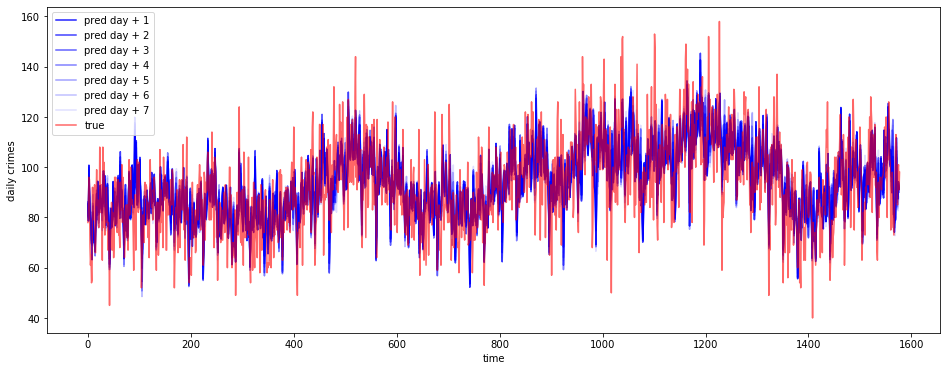

In [11]:
### PLOT TRUE vs PREDICTIONS ###

plt.figure(figsize=(16,6))

for t_h in range(time_h):
    plt.plot(pred[(time_h-t_h):-(t_h+1),t_h], 
             c='blue', alpha=1-1/(time_h+1)*(t_h+1),
             label=f"pred day + {t_h+1}")

plt.plot(y_valid[time_h:,0], c='red', alpha=0.6, label='true')

plt.ylabel('daily crimes'); plt.xlabel('time'); plt.legend(); plt.show()
np.set_printoptions(False)

In [12]:
### GET MODEL AND BASELINE MSE ###

mse_model = {}
mse_baseline = {}
    
for t_h in range(time_h):

    _mse = mse(y_valid[1:,t_h], y_valid[:-1,0])
    mse_baseline[f"day + {t_h+1}"] = _mse 

    _mse = mse(y_valid[:,t_h], pred[:,t_h])
    mse_model[f"day + {t_h+1}"] = _mse 

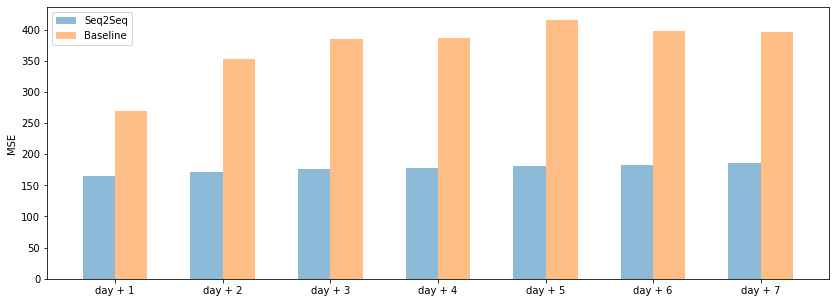

In [13]:
### PLOT AND COMPARE MSE ###

plt.figure(figsize=(14,5))

plt.bar(np.arange(len(mse_model))-0.15, mse_model.values(), alpha=0.5, width=0.3, label='Seq2Seq')
plt.bar(np.arange(len(mse_baseline))+0.15, mse_baseline.values(), alpha=0.5, width=0.3, label='Baseline')
plt.xticks(range(len(mse_baseline)), mse_baseline.keys())
plt.ylabel('MSE'); plt.legend()
np.set_printoptions(False)

# EXTREME VALUE ANALYSIS

In [14]:
### GET RESIDUALS ###

t_h = 1 # desired time forecasting horizon to compute the EVA

resid = np.abs(y_valid[:,t_h] - pred[:,t_h])
data = pd.Series(resid, index=(df.iloc[_id_valid[0]:_id_valid[-1]+1]).index, name='resid')

Text(0, 0.5, 'residuals')

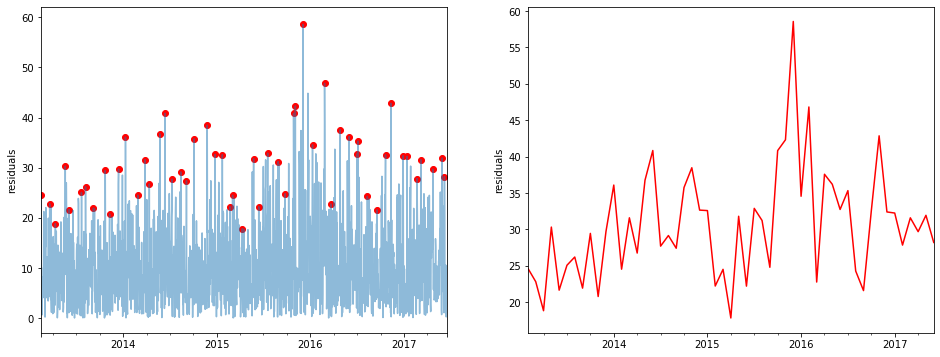

In [15]:
### PLOT BLOCK MAXIMA BLOCKS ###

plt.figure(figsize=(16,6))

plt.subplot(121)
data.plot(ax=plt.gca(), alpha=0.5)
plt.scatter(data[data.resample('1M').apply(lambda x: x.idxmax()).values].index, 
            data[data.resample('1M').apply(lambda x: x.idxmax()).values].values, c='red')
plt.ylabel('residuals')

plt.subplot(122)
data = data.resample('1M').max()
data.plot(ax=plt.gca(), c='red')
plt.ylabel('residuals')

In [16]:
### UTILITY FUNCTION FOR STATISTICS BOOTSTRAP ###

def bootstrap_ci(
    data, 
    statfunction=np.average, 
    alpha = 0.05, 
    n_samples = 100):

    """inspired by https://github.com/cgevans/scikits-bootstrap"""

    def bootstrap_ids(data, n_samples=100):
        for _ in range(n_samples):
            yield np.random.randint(data.shape[0], size=(data.shape[0],))    
    
    alphas = np.array([alpha/2, 1 - alpha/2])
    nvals = np.round((n_samples - 1) * alphas).astype(int)
    if np.any(nvals < 10) or np.any(nvals >= n_samples-10):
        warnings.warn("Some values used extremal samples; results are probably unstable. "
                      "Try to increase n_samples")

    data = np.array(data)
    if np.prod(data.shape) != max(data.shape):
        raise ValueError("Data must be 1D")
    data = data.ravel()
    
    boot_indexes = bootstrap_ids(data, n_samples)
    stat = np.asarray([statfunction(data[_ids]) for _ids in boot_indexes])
    stat.sort(axis=0)

    return stat[nvals]

In [17]:
### GET DISTRIBUTION FOR EXTREME RESIDUALS ###

f = Fitter(data, distributions=['genextreme','gumbel_r'], bins=20)
f.fit()

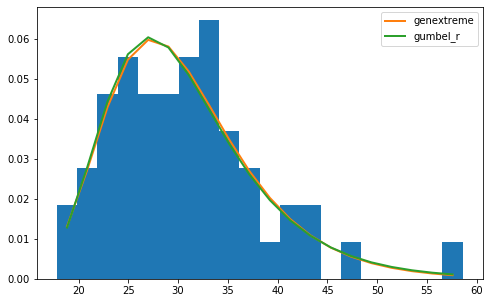

In [18]:
### PLOT DISTRIBUTION FOR EXTREME RESIDUALS ###

plt.figure(figsize=(8,5))

f.summary()
plt.grid(False)

In [19]:
best_dist = eval(f"stats.{list(f.get_best().keys())[0]}")
f.get_best()

{'genextreme': (0.02899787934754481, 27.239734675525096, 6.136422052158579)}

In [20]:
### RETRIVE ESTIMATED PARAMS FROM THE BEST DISTRIBUTION ###

best_params = best_dist.fit(data)
best_params

(0.02899787934754481, 27.239734675525096, 6.136422052158579)

In [21]:
### COMPUTE BOOTSTRAP INTERVALS FOR THE ESTIMATED BEST PARAMS ###

np.random.seed(111)
ci_params = bootstrap_ci(data, best_dist.fit, n_samples=500)
ci_params

array([[-0., 25.,  5.],
       [ 0., 30.,  7.]])

In [22]:
### DEFINE RETURN PERIODS AND ESTIMATED RETURN VALUES ###

eps = 1e-1
T = np.arange(1, 1000, eps) + eps # return periods
q = 1-1/T
ppf = best_dist.ppf(q, *best_params) # return values

In [23]:
### COMPUTE BOOTSTRAP INTERVALS FOR THE ESTIMATED RETURN VALUES ###

def gen_ppf(data, q):
    
    new_param = best_dist.fit(data)
    ppf = best_dist.ppf(q, *new_param)
    
    return ppf

np.random.seed(111)
ci_ppf = bootstrap_ci(data, lambda x: gen_ppf(x, q), n_samples=500, alpha=0.05)
ci_ppf

array([[ 20.,  22.,  23., ...,  46.,  46.,  46.],
       [ 24.,  26.,  27., ..., 105., 105., 105.]])

Text(0.5, 0, 'return periods (log scale)')

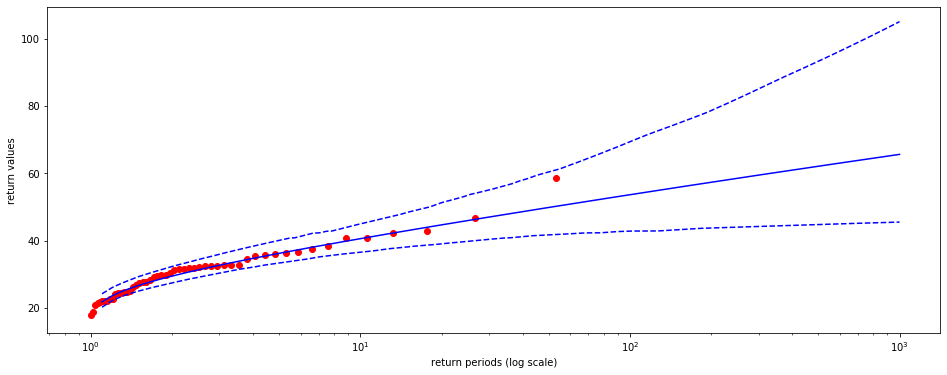

In [24]:
### RETURN VALUE PLOT ###

plt.figure(figsize=(16,6))

plt.semilogx(T, ppf, c='blue')
plt.semilogx(T, ci_ppf[0], c='blue', linestyle='--')
plt.semilogx(T, ci_ppf[1], c='blue', linestyle='--')

N = np.arange(1, len(data)+1)
plt.scatter(N[-1]/N, sorted(data)[::-1], color = 'red')
plt.ylabel('return values'); plt.xlabel('return periods (log scale)')

In [25]:
### CREATE A SHORT SUMMARY ###

eps = 1e-1
T = np.asarray([1, 2, 5, 10, 25, 50, 100]) + eps
q = 1-1/T
ppf = best_dist.ppf(q, *best_params)

np.random.seed(111)
ci_ppf = bootstrap_ci(data, lambda x: gen_ppf(x, q), n_samples=500, alpha=0.05)

summary = pd.DataFrame({
    'return_period':(T-eps).astype(int),
    'low_ci':ci_ppf[0], 
    'return_value':ppf, 
    'up_ci':ci_ppf[-1]
}).set_index('return_period')

summary

,low_ci,return_value,up_ci
return_period,,,
1,20.233287,21.804239,24.222223
2,27.835444,29.898284,32.779873
5,33.446171,36.376841,40.255112
10,36.612446,40.668314,45.075642
25,39.820719,46.007343,53.561490
50,41.734465,49.889810,60.446690
100,42.860351,53.671822,69.420590
